<p style="font-family: 'Courier New', Courier, monospace; font-size: 40px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: DATA SORTING
</p>

###  Notebook Summary 
This Notebook processes unsorted measurement data by:
- Converting and validating time data.
- Aggregating daily counts and visualizing the data.
- Extracting and analyzing unique gateway IDs.
- Filtering data for a specific gateway ("kerlink001").
- Deduplicating data based on time and frame count differences.

###  1. Import Libraries and Load Data

This cell imports the required libraries and loads the dataset from a CSV file. It then prints basic information about the DataFrame.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('../all_data_files/unsorted_combined_measurements_data.csv', low_memory=False)
print("Initial DataFrame Info:")
df.info()

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2598296 entries, 0 to 2598295
Data columns (total 82 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   correlation_ids_0                                        object 
 1   device_id                                                object 
 2   end_device_ids_application_ids_application_id            object 
 3   end_device_ids_dev_addr                                  object 
 4   end_device_ids_dev_eui                                   object 
 5   end_device_ids_device_id                                 object 
 6   end_device_ids_join_eui                                  int64  
 7   received_at                                              object 
 8   time                                                     object 
 9   uplink_message_confirmed                                 bool   
 10  uplink_message_con

### 2. Preprocess Time Data

Convert the 'time' column to datetime (with UTC) and remove invalid entries. Then, extract the date for daily aggregation and plot the unsorted data counts per day.

Found 2 invalid time rows; dropping them.


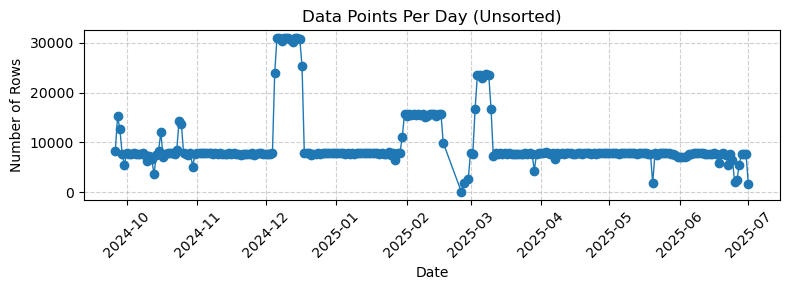

In [6]:
# Create a working copy and convert 'time' to datetime
df = df.copy()
df['time'] = pd.to_datetime(df['time'].astype(str), errors='coerce', utc=True)

# Report and drop rows with invalid datetime values
invalid_times = df[df['time'].isna()]
if not invalid_times.empty:
    print(f"Found {len(invalid_times)} invalid time rows; dropping them.")
df = df.dropna(subset=['time'])

# Extract date for aggregation
df['date'] = df['time'].dt.date

# Plot daily counts (unsorted data)
daily_counts_unsorted = df.groupby('date').size()
plt.figure(figsize=(8, 3))
daily_counts_unsorted.plot(kind='line', marker='o', linestyle='-', linewidth=1)
plt.title('Data Points Per Day (Unsorted)')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 3. Unique Gateway Analysis

Extract unique gateway IDs from metadata columns (e.g., `uplink_message_rx_metadata_0_gateway_ids_gateway_id`), display their count, list them, and compute the number of rows associated with each gateway.


In [8]:
# Define gateway metadata columns
gateway_cols = [f'uplink_message_rx_metadata_{i}_gateway_ids_gateway_id' for i in range(3)]
unique_gateways = set()

# Extract unique gateway IDs from available columns
for col in gateway_cols:
    if col in df.columns:
        unique_gateways.update(df[col].dropna().unique())

print("Number of unique gateways:", len(unique_gateways))
print("Unique gateway IDs:", unique_gateways)

# Count rows per gateway
gateway_row_counts = {}
for gw in unique_gateways:
    mask = pd.Series(False, index=df.index)
    for col in gateway_cols:
        if col in df.columns:
            mask |= (df[col] == gw)
    gateway_row_counts[gw] = mask.sum()

print("\nRows per gateway:")
for gw, count in gateway_row_counts.items():
    print(f"{gw}: {count}")

Number of unique gateways: 5
Unique gateway IDs: {'eui-a84041ffff22def8', 'eui-a84041ffff22dea4', 'a84041fdfe275e82', 'kerlink-istation', 'kerlink001'}

Rows per gateway:
eui-a84041ffff22def8: 1742027
eui-a84041ffff22dea4: 328809
a84041fdfe275e82: 32
kerlink-istation: 15
kerlink001: 2564903


### 4. Filter Data for Target Gateway

Filter the dataset to retain only rows corresponding to the target gateway (`"kerlink001"`). The filtered DataFrame will be used for subsequent deduplication and analysis.


In [10]:
target_gateway = "kerlink001"
mask = pd.Series(False, index=df.index)
for col in gateway_cols:
    if col in df.columns:
        mask |= (df[col] == target_gateway)

# Filter the DataFrame for the target gateway and reset the index
df_target = df[mask].reset_index(drop=True)
print("Filtered DataFrame shape for target gateway:", df_target.shape)

Filtered DataFrame shape for target gateway: (2564903, 83)


### 5. Deduplicate Data Based on Time and Frame Count

Sort the filtered data by device and time, then remove duplicate transmissions where the frame count difference is zero and the time difference is less than 2 seconds. Finally, plot the deduplicated daily counts.


Original shape: (2564903, 85)
Deduplicated shape: (1995000, 83)


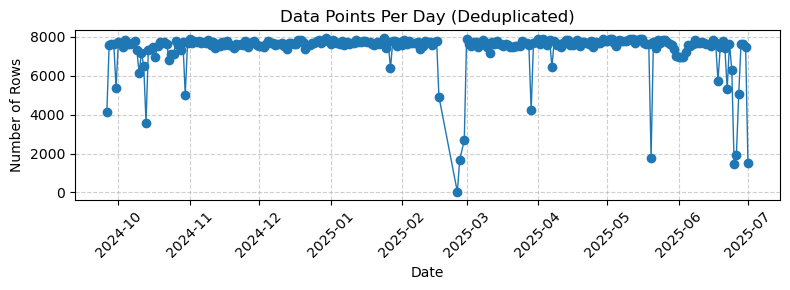

In [12]:
# Sort by device ID and time
df_target = df_target.sort_values(["end_device_ids_device_id", "time"]).copy()

# Compute time difference and frame counter difference for each device
df_target["dt"] = df_target.groupby("end_device_ids_device_id")["time"].diff().dt.total_seconds()
df_target["df_cnt_diff"] = df_target.groupby("end_device_ids_device_id")["uplink_message_f_cnt"].diff()

# Remove duplicates: where frame count remains unchanged and time diff < 2 seconds
non_duplicate_mask = ~((df_target["df_cnt_diff"] == 0) & (df_target["dt"] < 2.0))
df_dedup = df_target[non_duplicate_mask].copy()

# Clean up intermediate columns
df_dedup.drop(columns=["dt", "df_cnt_diff"], inplace=True, errors="ignore")
df_dedup.reset_index(drop=True, inplace=True)

print("Original shape:", df_target.shape)
print("Deduplicated shape:", df_dedup.shape)

# Plot daily counts for deduplicated data
df_dedup["date"] = df_dedup["time"].dt.date
daily_counts_dedup = df_dedup.groupby("date").size()
plt.figure(figsize=(8, 3))
daily_counts_dedup.plot(kind='line', marker='o', linestyle='-', linewidth=1)
plt.title('Data Points Per Day (Deduplicated)')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 6. Save Cleaned Data and Preview

Save the cleaned, deduplicated dataset to a CSV file and display the last 10 rows as a preview.

In [14]:
# Save the cleaned data to CSV
df_dedup.to_csv('../all_data_files/combined_measurements_data.csv', index=False)
print("Data cleaning and deduplication completed. CSV file saved.")

# Display the tail of the deduplicated DataFrame
df_dedup.tail(10)

Data cleaning and deduplication completed. CSV file saved.


,correlation_ids_0,device_id,end_device_ids_application_ids_application_id,end_device_ids_dev_addr,end_device_ids_dev_eui,end_device_ids_device_id,end_device_ids_join_eui,received_at,time,uplink_message_confirmed,...,uplink_message_settings_data_rate_lora_spreading_factor,uplink_message_settings_frequency,uplink_message_settings_time,uplink_message_settings_timestamp,uplink_message_version_ids_band_id,uplink_message_version_ids_brand_id,uplink_message_version_ids_firmware_version,uplink_message_version_ids_hardware_version,uplink_message_version_ids_model_id,date
1994990,gs:uplink:01JJRVY5D7HRC56E69HJNR1BAJ,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:07:57.944410062Z,2025-01-29 11:07:57.971066+00:00,True,...,12.0,868500000,2025-01-29T11:07:57.675045Z,3.211643e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994991,gs:uplink:01JJRW0G2RXG9M7MTBY4TNVRZ5,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:09:14.405190448Z,2025-01-29 11:09:14.433548+00:00,True,...,12.0,867900000,2025-01-29T11:09:14.142329Z,3.288110e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994992,gs:uplink:01JJRW3NEC152Y4RH68WMK5JQN,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:10:58.203436452Z,2025-01-29 11:10:58.231703+00:00,True,...,11.0,868100000,2025-01-29T11:10:57.957262Z,3.391925e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994993,gs:uplink:01JJRW6042AY1EC1JCAPWG36KY,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:12:14.686310289Z,2025-01-29 11:12:14.714619+00:00,True,...,11.0,867500000,2025-01-29T11:12:14.423554Z,3.468392e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994994,gs:uplink:01JJRW78WMJDKKJ3ARVFR473R9,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:12:56.423484950Z,2025-01-29 11:12:56.450676+00:00,True,...,11.0,868500000,2025-01-29T11:12:56.173194Z,3.510141e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994995,gs:uplink:01JJRW93HHYTCP1G6DEB524JPX,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:13:56.483298039Z,2025-01-29 11:13:56.511742+00:00,True,...,11.0,867900000,2025-01-29T11:13:56.225962Z,3.570194e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994996,gs:uplink:01JJRWAXN566DRPYZ0EVXK1944,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:14:55.986247587Z,2025-01-29 11:14:56.014379+00:00,True,...,10.0,868300000,2025-01-29T11:14:55.747108Z,3.629715e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994997,gs:uplink:01JJRWCRA1CNF45JY7F8RQSGWK,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:15:56.045457219Z,2025-01-29 11:15:56.074514+00:00,True,...,10.0,867900000,2025-01-29T11:15:55.802812Z,3.689771e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994998,gs:uplink:01JJRWEJYSJVH43SGSPYDY3K60,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:16:56.105283552Z,2025-01-29 11:16:56.132382+00:00,True,...,10.0,867500000,2025-01-29T11:16:55.859469Z,3.749827e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
1994999,gs:uplink:01JJRWGDKHQN7BP9CMK1FSKVE2,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:17:56.162296967Z,2025-01-29 11:17:56.189602+00:00,True,...,10.0,867100000,2025-01-29T11:17:55.916136Z,3.809884e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29
